<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

Aim: Preprocess annotated human brain single-cell data from Siletti 2022 bioRxiv

In [1]:
from datetime import date
date.today().strftime('%d/%m/%Y')

'06/03/2025'

In [2]:
import os
import random
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns

In [3]:
import anndata as ad
import scanpy as sc
import scipy as sci
sc.settings.verbosity = 3

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata

In [4]:
#import loompy

In [5]:
import utils

In [6]:
main_dir='/cluster2/sfrerich/P6/P06_vasc_scRNAseq' # HPC

In [7]:
dataset_name = "Siletti2022" # Siletti 2022 biorXiv 
organism = "Human"

In [8]:
target_genes = ["Foxo1", "Tek", "Nos3", "Htra1", "Egfl8", "Flt1", "Kdr", "Ptprb", "Nrp1", "Nrp2", "Efnb2", "Itgb1", "Itga6", "Angpt2", "Cdh5", "Cldn5", "Ocln", "Ctnnb1"]
target_genes = [gene.upper() for gene in target_genes]

In [9]:
genes_subset = ["FOXF2"] + target_genes

# Load + format data

Annotated by authors

### All cells

All superclusters downloaded from cellxgene https://cellxgene.cziscience.com/collections/283d65eb-dd53-496d-adb7-7570c7caa443 
(23/02/2023) except for Miscancelleous

In [11]:
# run once

In [12]:
f=os.listdir(os.path.join(main_dir,'Siletti2022','all_cellxgene'))
f

['nonneuronal.h5ad',
 'Hippocampal-CA1-3.h5ad',
 'Deep-layer-near-projecting.h5ad',
 'Amygdala-excitatory.h5ad',
 'upper-layer-intratelencephalic.h5ad',
 'Upper-rhombic-lip.h5ad',
 'splatter-neurons.h5ad',
 'Hippocampal-CA4.h5ad',
 'Medium-spiny-neuron.h5ad',
 'Mammillary-body.h5ad',
 'Hippocampal-dentate-gyrus.h5ad',
 'LAMP5-LHX6-and-Chandelier.h5ad',
 'MGE-interneuron.h5ad',
 'Lower-rhombic-lip.h5ad',
 'Eccentric-medium-spiny-neuron.h5ad',
 'Thalamic-excitatory.h5ad',
 'Deep-layer-corticothalamic-and-6b.h5ad',
 'Midbrain-derived-inhibitory.h5ad',
 'deep-layer-intratelencephalic.h5ad',
 'Cerebellar-inhibitory.h5ad',
 'CGE-interneuron.h5ad']

In [ ]:
%%time
# load, format, normalize, export each h5ad object
for p in f[16:]:
    print("processing "+p)
    adata = ad.read_h5ad(os.path.join(main_dir,'Siletti2022','all_cellxgene',p))
    adatas = adata[adata.obs["BadCells"] == 0]
    adata = adata[adata.obs["tissue"] != "Spinal cord"]
    adata.obs = adata.obs[["supercluster_term", "cell_type", "assay", "organism", "disease", "tissue", "BadCells"]]
    adata.var = adata.var[["Gene","feature_name"]]
    del adata.uns
    adata.var_names = adata.var["Gene"].tolist()
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    # log-normalize
    #adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata,inplace=True)
    sc.pp.log1p(adata)
    #adata.layers["normalized"] = adata.X.copy()
    print("saving "+p)
    adata.write_h5ad(os.path.join(main_dir,'Siletti2022','all_reduced_normalized',p.split(".")[0]+'_reduced.h5ad.gz'), compression="gzip")
del adata

In [10]:
# then load from here

In [11]:
f=os.listdir(os.path.join(main_dir,'Siletti2022','all_reduced_normalized'))
f

['Hippocampal-CA1-3_reduced.h5ad.gz',
 'Deep-layer-corticothalamic-and-6b_reduced.h5ad.gz',
 'Medium-spiny-neuron_reduced.h5ad.gz',
 'Amygdala-excitatory_reduced.h5ad.gz',
 'Hippocampal-CA4_reduced.h5ad.gz',
 'Deep-layer-near-projecting_reduced.h5ad.gz',
 'Cerebellar-inhibitory_reduced.h5ad.gz',
 'MGE-interneuron_reduced.h5ad.gz',
 'upper-layer-intratelencephalic_reduced.h5ad.gz',
 'Mammillary-body_reduced.h5ad.gz',
 'nonneuronal_reduced.h5ad.gz',
 'splatter-neurons_reduced.h5ad.gz',
 'Midbrain-derived-inhibitory_reduced.h5ad.gz',
 'Thalamic-excitatory_reduced.h5ad.gz',
 'Upper-rhombic-lip_reduced.h5ad.gz',
 'Lower-rhombic-lip_reduced.h5ad.gz',
 'deep-layer-intratelencephalic_reduced.h5ad.gz',
 'LAMP5-LHX6-and-Chandelier_reduced.h5ad.gz',
 'Eccentric-medium-spiny-neuron_reduced.h5ad.gz',
 'Hippocampal-dentate-gyrus_reduced.h5ad.gz',
 'CGE-interneuron_reduced.h5ad.gz']

In [12]:
adatas = {p.split(".")[0]:ad.read_h5ad(os.path.join(main_dir,'Siletti2022','all_reduced_normalized',p)) for p in f}

In [13]:
adatas.keys()

dict_keys(['Hippocampal-CA1-3_reduced', 'Deep-layer-corticothalamic-and-6b_reduced', 'Medium-spiny-neuron_reduced', 'Amygdala-excitatory_reduced', 'Hippocampal-CA4_reduced', 'Deep-layer-near-projecting_reduced', 'Cerebellar-inhibitory_reduced', 'MGE-interneuron_reduced', 'upper-layer-intratelencephalic_reduced', 'Mammillary-body_reduced', 'nonneuronal_reduced', 'splatter-neurons_reduced', 'Midbrain-derived-inhibitory_reduced', 'Thalamic-excitatory_reduced', 'Upper-rhombic-lip_reduced', 'Lower-rhombic-lip_reduced', 'deep-layer-intratelencephalic_reduced', 'LAMP5-LHX6-and-Chandelier_reduced', 'Eccentric-medium-spiny-neuron_reduced', 'Hippocampal-dentate-gyrus_reduced', 'CGE-interneuron_reduced'])

In [14]:
adatas.values()

dict_values([AnnData object with n_obs × n_vars = 74979 × 59357
    obs: 'supercluster_term', 'cell_type', 'assay', 'organism', 'disease', 'tissue', 'BadCells'
    var: 'Gene', 'feature_name'
    uns: 'log1p'
    obsm: 'X_UMAP', 'X_tSNE', AnnData object with n_obs × n_vars = 78396 × 59357
    obs: 'supercluster_term', 'cell_type', 'assay', 'organism', 'disease', 'tissue', 'BadCells'
    var: 'Gene', 'feature_name'
    uns: 'log1p'
    obsm: 'X_UMAP', 'X_tSNE', AnnData object with n_obs × n_vars = 152189 × 59357
    obs: 'supercluster_term', 'cell_type', 'assay', 'organism', 'disease', 'tissue', 'BadCells'
    var: 'Gene', 'feature_name'
    uns: 'log1p'
    obsm: 'X_UMAP', 'X_tSNE', AnnData object with n_obs × n_vars = 109452 × 59357
    obs: 'supercluster_term', 'cell_type', 'assay', 'organism', 'disease', 'tissue', 'BadCells'
    var: 'Gene', 'feature_name'
    uns: 'log1p'
    obsm: 'X_UMAP', 'X_tSNE', AnnData object with n_obs × n_vars = 10654 × 59357
    obs: 'supercluster_term', 

In [15]:
# too large for standard merge, use AnnCollection instead
# adata2 = ad.concat(adatas, axis=0, join="inner", merge="first")

In [16]:
from anndata.experimental.multi_files import AnnCollection

adata2 = AnnCollection(adatas, join_vars='inner', label='dataset')
adata2

AnnCollection object with n_obs × n_vars = 3344148 × 59357
  constructed from 21 AnnData objects
    view of obsm: 'X_UMAP', 'X_tSNE'
    obs: 'supercluster_term', 'cell_type', 'assay', 'organism', 'disease', 'tissue', 'BadCells', 'dataset'

In [17]:
[i for i in adata2.var_names if "NOS3" in i]

['NANOS3', 'NOS3']

In [18]:
pd.value_counts(adata2.obs["cell_type"])

neuron                                    2455885
oligodendrocyte                            494966
astrocyte                                  155025
oligodendrocyte precursor cell             105734
central nervous system macrophage           91838
fibroblast                                   9156
Bergmann glial cell                          8041
choroid plexus epithelial cell               7689
ependymal cell                               5882
endothelial cell                             5165
pericyte                                     3693
vascular associated smooth muscle cell       1074
Name: cell_type, dtype: int64

In [19]:
new_cluster_names = {'Bergmann glial cell':'Astrocytes',
                     'astrocyte':'Astrocytes',
                     'central nervous system macrophage':'Macrophages',
                     'choroid plexus epithelial cell':'Choroid plexus epithelial cells',
                     'endothelial cell':'Endothelial cells',
                     'ependymal cell':'Ependymal cells',
                     'fibroblast':'Fibroblasts',
                     'neuron':'Neurons',
                     'oligodendrocyte':'Oligos',
                     'oligodendrocyte precursor cell':'OPCs',
                     'pericyte':'Pericytes',
                     'vascular associated smooth muscle cell':'SMCs'}
#new_cluster_names=list(new_cluster_names.values())

In [20]:
adata2.obs['clusters'] = (
    adata2.obs['cell_type']
    .map(new_cluster_names)
    .astype('category')
)

In [21]:
pd.value_counts(adata2.obs["clusters"])

Neurons                            2455885
Oligos                              494966
Astrocytes                          163066
OPCs                                105734
Macrophages                          91838
Fibroblasts                           9156
Choroid plexus epithelial cells       7689
Ependymal cells                       5882
Endothelial cells                     5165
Pericytes                             3693
SMCs                                  1074
Name: clusters, dtype: int64

In [22]:
#adata3 = adata2.to_adata() # does not contain .X - must subset first into AnnCollectionView object

In [23]:
# subset genes
adata3 = adata2[:,adata2.var_names.isin(genes_subset)]

In [24]:
adata3

AnnCollectionView object with n_obs × n_vars = 3344148 × 19
    obsm: 'X_UMAP', 'X_tSNE'
    obs: 'supercluster_term', 'cell_type', 'assay', 'organism', 'disease', 'tissue', 'BadCells', 'dataset', 'clusters'

In [25]:
adata3 = adata3.to_adata()

In [26]:
adata3

AnnData object with n_obs × n_vars = 3344148 × 19
    obs: 'supercluster_term', 'cell_type', 'assay', 'organism', 'disease', 'tissue', 'BadCells', 'dataset', 'clusters'
    obsm: 'X_UMAP', 'X_tSNE'

In [27]:
adata3.obsm["X_umap"] = adata3.obsm["X_UMAP"]

In [28]:
adata3.var_names

Index(['FOXF2', 'CTNNB1', 'HTRA1', 'FLT1', 'KDR', 'NRP1', 'ANGPT2', 'CDH5',
       'OCLN', 'FOXO1', 'TEK', 'CLDN5', 'EFNB2', 'PTPRB', 'NOS3', 'NRP2',
       'ITGA6', 'ITGB1', 'EGFL8'],
      dtype='object')

In [29]:
del adata2

In [30]:
# check if data is normalized
adata3.X.max()

5.916369

/tmp/ipykernel_236358/362381610.py:8: UserWarning: 
The palette list has fewer values (4) than needed (15) and will cycle, which may produce an uninterpretable plot.
  pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',4)), lw=0.3) # genes with 0 expression are excluded


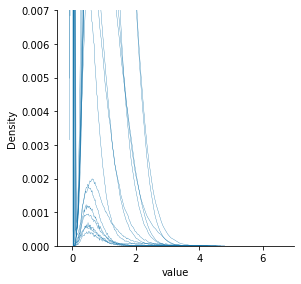

In [31]:
# show expression of genes (across all spots)
random_genes=random.sample(range(0, adata3.X.shape[1]), 15)
adata_sub = adata3[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',4)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007))
sns.set_theme(style='white')
plt.show()

/tmp/ipykernel_236358/1501902166.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',4)))


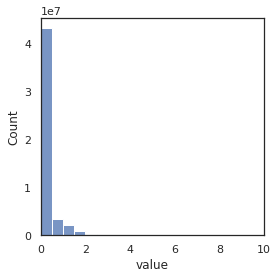

In [32]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_theme(style='white')
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',4)))
pl.set(xlim=(0, 10));
plt.show()

In [33]:
adata3.layers["normalized"] = adata3.X

---

# Focus on: Foxf2

In [34]:
gene="FOXF2"

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


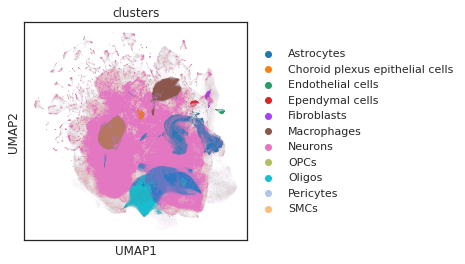

In [35]:
sc.pl.umap(adata3, color='clusters', size=0.05)

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


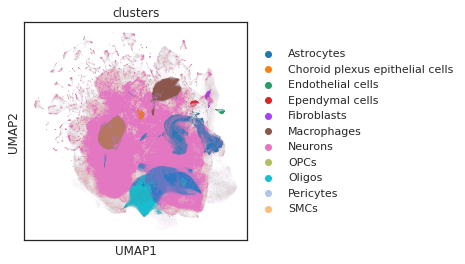

In [36]:
sc.pl.umap(adata3, color='clusters', size=0.05)

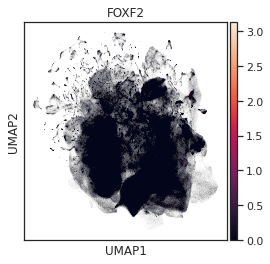

In [37]:
sc.pl.umap(adata3, color=gene, size=0.05)

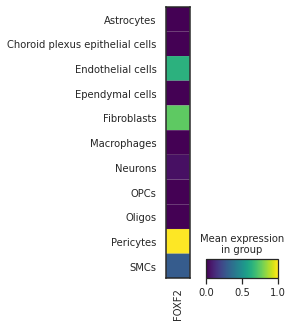

In [38]:
sc.pl.matrixplot(adata3, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


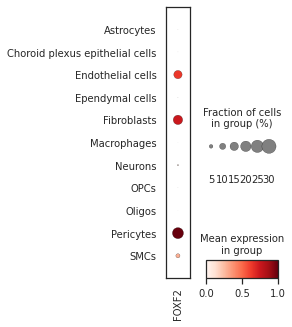

In [39]:
sc.pl.dotplot(adata3, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

In [40]:
utils.summarize_gene_expression(adata = adata3, gene = gene, groupby = "clusters", 
                                study_name = dataset_name, organism = organism,
                                export = True, output_dir = os.path.join(main_dir, "Foxf2_summarized")
                               )

Exported to /cluster2/sfrerich/P6/P06_vasc_scRNAseq/Foxf2_summarized/20250306_FOXF2_Siletti2022_layernormalized.csv


,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000600,0.000356,FOXF2,Siletti2022,Human,163066
Choroid plexus epithelial cells,0.000000,0.000260,FOXF2,Siletti2022,Human,7689
Endothelial cells,0.638464,0.147531,FOXF2,Siletti2022,Human,5165
Ependymal cells,0.002025,0.000680,FOXF2,Siletti2022,Human,5882
Fibroblasts,0.751317,0.173657,FOXF2,Siletti2022,Human,9156
Macrophages,0.000200,0.000120,FOXF2,Siletti2022,Human,91838
Neurons,0.042747,0.013643,FOXF2,Siletti2022,Human,2455885
OPCs,0.000568,0.000350,FOXF2,Siletti2022,Human,105734
Oligos,0.000069,0.000101,FOXF2,Siletti2022,Human,494966


# Focus on: Other genes

In [41]:
other_genes_results = {
    gene: utils.summarize_gene_expression(adata3, gene, study_name = dataset_name, organism = organism, groupby = "clusters",
                                          output_dir=os.path.join(main_dir, "Other_genes_summarized"), export=True
                                         ) for gene in target_genes
}

Exported to /cluster2/sfrerich/P6/P06_vasc_scRNAseq/Other_genes_summarized/20250306_FOXO1_Siletti2022_layernormalized.csv
Exported to /cluster2/sfrerich/P6/P06_vasc_scRNAseq/Other_genes_summarized/20250306_TEK_Siletti2022_layernormalized.csv
Exported to /cluster2/sfrerich/P6/P06_vasc_scRNAseq/Other_genes_summarized/20250306_NOS3_Siletti2022_layernormalized.csv
Exported to /cluster2/sfrerich/P6/P06_vasc_scRNAseq/Other_genes_summarized/20250306_HTRA1_Siletti2022_layernormalized.csv
Exported to /cluster2/sfrerich/P6/P06_vasc_scRNAseq/Other_genes_summarized/20250306_EGFL8_Siletti2022_layernormalized.csv
Exported to /cluster2/sfrerich/P6/P06_vasc_scRNAseq/Other_genes_summarized/20250306_FLT1_Siletti2022_layernormalized.csv
Exported to /cluster2/sfrerich/P6/P06_vasc_scRNAseq/Other_genes_summarized/20250306_KDR_Siletti2022_layernormalized.csv
Exported to /cluster2/sfrerich/P6/P06_vasc_scRNAseq/Other_genes_summarized/20250306_PTPRB_Siletti2022_layernormalized.csv
Exported to /cluster2/sfrerich

In [42]:
# some plots

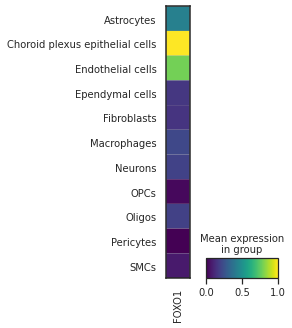

In [43]:
sc.pl.matrixplot(adata3, [target_genes[0]], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


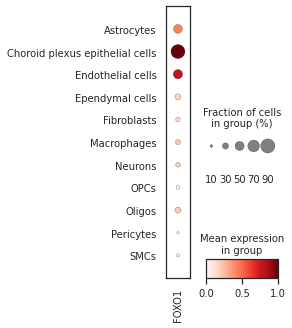

In [44]:
sc.pl.dotplot(adata3, [target_genes[0]], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

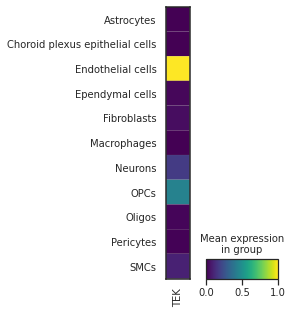

In [45]:
sc.pl.matrixplot(adata3, [target_genes[1]], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


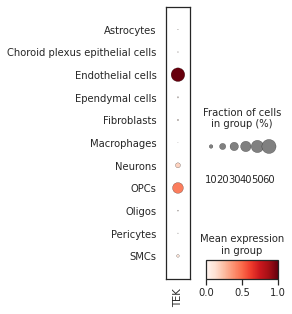

In [46]:
sc.pl.dotplot(adata3, [target_genes[1]], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

# Session Info

In [47]:
sc.logging.print_versions()

-----
anndata     0.11.1
scanpy      1.9.1
-----
PIL                         9.4.0
asciitree                   NA
asttokens                   NA
backcall                    0.2.0
bottleneck                  1.3.5
cffi                        1.15.1
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
exceptiongroup              1.2.2
executing                   0.8.3
fasteners                   0.19
h5py                        3.8.0
igraph                      0.11.8
ipykernel                   6.9.1
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
joblib                      1.2.0
jupyter_server              1.23.4
kiwisolver                  1.4.4
leidenalg                   0.10.2
llvmlite                    0.39.1
matplotlib                  3.6.3
matp